「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第5部第3章 状態空間モデルによる予測と補完」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備
## パッケージの読み込み

In [1]:
import pystan
import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'

# 自作のplotSSM関数を読み込み
from plotSSM import plotSSM

## データの読み込み

In [2]:
sales_df_all = pd.read_csv('5-2-1-sales-ts-1.csv')
sales_df_all['date'] = pd.to_datetime(sales_df_all['date'])
sales_df_all.head(n=3)

,date,sales
0,2010-01-01,23.9
1,2010-01-02,19.0
2,2010-01-03,20.3


# ローカルレベルモデルによる予測の実行


## データの準備

In [3]:
data_list_pred = dict(T=len(sales_df_all),
                      y=sales_df_all['sales'],
                      pred_term=20)

## モデルの推定

In [4]:
# stanコードの記述(5-3-1-local-level-pred.stan)
stan_code = '''
data {
  int T;         // データ取得期間の長さ
  vector[T] y;   // 観測値
  int pred_term; // 予測期間の長さ
}

parameters {
  vector[T] mu;       // 状態の推定値(水準成分)
  real<lower=0> s_w;  // 過程誤差の標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(mu[i], s_v);
  }
}

generated quantities{
  vector[T + pred_term] mu_pred; // 予測値も含めた状態の推定値
  
  // データ取得期間においては、状態推定値muと同じ
  mu_pred[1:T] = mu;
  
  // データ取得期間を超えた部分を予測
  for(i in 1:pred_term){
    mu_pred[T + i] = normal_rng(mu_pred[T + i - 1], s_w);
  }
}

'''

# モデルのコンパイル
stan_model_llp = pystan.StanModel(model_code=stan_code)

# サンプリング
local_level_pred = stan_model_llp.sampling(data=data_list_pred,
                                           seed=1,
                                           n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_034be78dc0fa71b8d5e9e6b8edac86e4 NOW.


## 参考：結果の確認

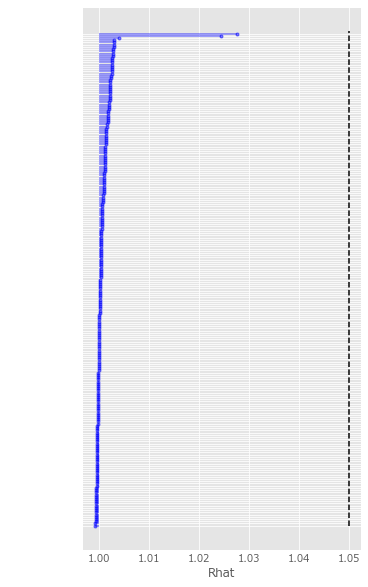

In [5]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary = pd.DataFrame(local_level_pred.summary()['summary'],
                       columns=local_level_pred.summary()['summary_colnames'],
                       index=local_level_pred.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary)

## 参考：結果の確認

In [6]:
print(local_level_pred.stansummary(pars=["s_w", "s_v", "lp__"],
                                   probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_034be78dc0fa71b8d5e9e6b8edac86e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w     1.3    0.02   0.32   0.79   1.26   2.05    230   1.02
s_v    2.87  6.3e-3   0.26   2.39   2.86   3.42   1740    1.0
lp__ -225.5    1.35  19.48 -264.7 -225.3 -188.2    207   1.03

Samples were drawn using NUTS at Thu Sep 10 22:36:29 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 図示

### 予測対象期間も含めた日付を用意

In [7]:
date_plot = pd.date_range('2010-1-1', periods=120, freq='D')

### 生成された乱数を格納

In [8]:
mcmc_sample = local_level_pred.extract()

### 予測結果の図示

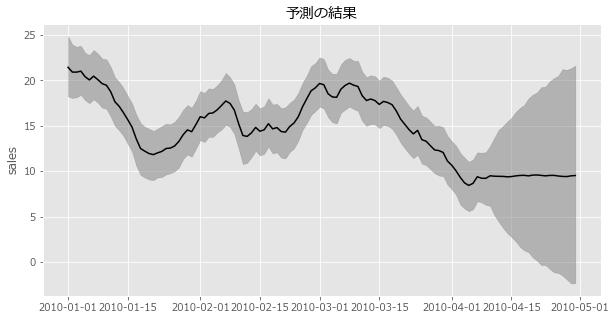

In [9]:
# グラフ描画領域の作成
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)

# plotSSM関数によるグラフ作成
plotSSM(mcmc_sample,
        time_vec=date_plot,
        state_name='mu_pred',
        graph_title='予測の結果',
        y_label='sales',
        axes=ax)

# グラフの描画
plt.show()

# 欠損があるデータ

## データの読み込み

In [10]:
sales_df_NA = pd.read_csv('5-3-1-sales-ts-1-NA.csv')

## 日付をdatetime型にする

In [11]:
sales_df_NA['date'] = pd.to_datetime(sales_df_NA['date'])

## 売り上げデータに一部欠損がある

In [12]:
sales_df_NA.head(n=3)

,date,sales
0,2010-01-01,23.9
1,2010-01-02,19.0
2,2010-01-03,NaN


# 欠損データの取り扱い

## NaN値がある行を削除

In [13]:
sales_df_omit_NA = sales_df_NA.dropna(axis=0)
sales_df_omit_NA.head(n=3)

,date,sales
0,2010-01-01,23.9
1,2010-01-02,19.0
3,2010-01-04,24.2


## データを取得した期間

In [14]:
len(sales_df_NA)

100

## 正しくデータが取得できた日数

In [15]:
len(sales_df_omit_NA)

74

## NaN値がどこにあるのかを判別

In [16]:
[(n, not i) for n, i in enumerate(sales_df_NA['sales'].isnull())]

[(0, True),
 (1, True),
 (2, False),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, True),
 (8, True),
 (9, True),
 (10, True),
 (11, True),
 (12, True),
 (13, True),
 (14, True),
 (15, True),
 (16, True),
 (17, True),
 (18, True),
 (19, True),
 (20, True),
 (21, True),
 (22, True),
 (23, True),
 (24, True),
 (25, True),
 (26, False),
 (27, False),
 (28, False),
 (29, False),
 (30, False),
 (31, False),
 (32, False),
 (33, False),
 (34, False),
 (35, False),
 (36, False),
 (37, False),
 (38, False),
 (39, False),
 (40, False),
 (41, False),
 (42, False),
 (43, False),
 (44, False),
 (45, False),
 (46, False),
 (47, False),
 (48, True),
 (49, True),
 (50, True),
 (51, True),
 (52, True),
 (53, True),
 (54, True),
 (55, True),
 (56, True),
 (57, True),
 (58, True),
 (59, True),
 (60, True),
 (61, True),
 (62, True),
 (63, True),
 (64, True),
 (65, True),
 (66, True),
 (67, True),
 (68, True),
 (69, True),
 (70, True),
 (71, True),
 (72, True),
 (73, True),
 (74, True),
 (75, True),

## データがある行番号の取得

In [17]:
sales_df_omit_NA.index

Int64Index([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 48, 49, 50, 51, 52, 53, 54, 55, 56,
            57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
            93, 95, 96, 97, 98, 99],
           dtype='int64')

# ローカルレベルモデルによる補間の実行

## データの準備

In [18]:
data_list_interpolation = dict(T=len(sales_df_NA),
                               len_obs=len(sales_df_omit_NA),
                               y=sales_df_omit_NA['sales'],
                               obs_no=sales_df_omit_NA.index+1) # pythonはインデックスが0始まりなので1を加えておく

## モデルの推定

In [19]:
# stanコードの記述(5-3-2-local-level-interpolation.stan)
stan_code = '''
data {
  int T;               // データ取得期間の長さ
  int len_obs;         // 観測値が得られた個数
  vector[len_obs] y;   // 観測値
  int obs_no[len_obs]; // 観測値が得られた時点
}

parameters {
  vector[T] mu;       // 状態の推定値(水準成分)
  real<lower=0> s_w;  // 過程誤差の標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // 観測方程式に従い、観測値が得られる
  // ただし、「観測値が得られた時点」でのみ実行する
  for(i in 1:len_obs) {
    y[i] ~ normal(mu[obs_no[i]], s_v);
  }
}

'''

# モデルのコンパイル
stan_model_lli = pystan.StanModel(model_code=stan_code)

# サンプリング
local_level_interpolation = stan_model_lli.sampling(data=data_list_interpolation,
                                           seed=1,
                                           iter=4000,
                                           n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_28d0b3c36d27d089631f3604cc43a67b NOW.


## 参考：収束の確認

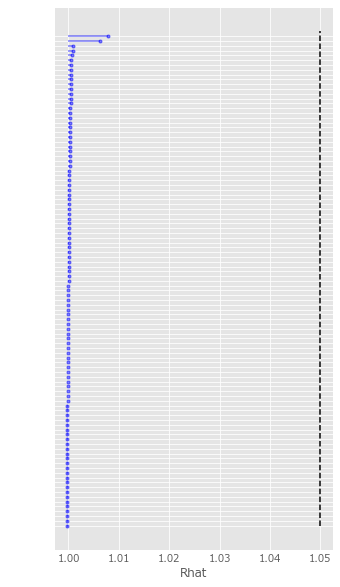

In [20]:
# 各推定結果のデータフレームを作成
summary_lli = pd.DataFrame(
    local_level_interpolation.summary()['summary'],
    columns=local_level_interpolation.summary()['summary_colnames'],
    index=local_level_interpolation.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary_lli)

## 参考：結果の表示

In [21]:
print(local_level_interpolation.stansummary(pars=["s_w", "s_v", "lp__"],
                                            probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_28d0b3c36d27d089631f3604cc43a67b.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w     1.3    0.01   0.31   0.83   1.26   2.02    582   1.01
s_v    2.65  4.5e-3   0.29   2.14   2.64   3.26   4023    1.0
lp__ -179.2    0.86  19.47 -219.5 -178.6 -143.1    513   1.01

Samples were drawn using NUTS at Thu Sep 10 22:37:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 図示
### 生成された乱数を格納

In [22]:
mcmc_sample_interpolation = local_level_interpolation.extract()

### 図示

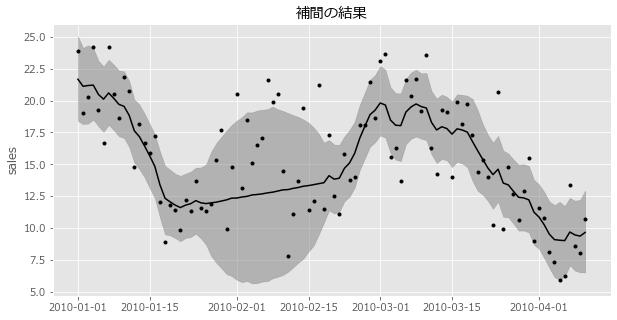

In [23]:
# グラフ描画領域の作成
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)

# plotSSM関数によるグラフ作成
plotSSM(mcmc_sample_interpolation,
        time_vec=sales_df_all['date'],
        obs_vec=sales_df_all['sales'],
        state_name='mu',
        graph_title='補間の結果',
        y_label='sales',
        axes=ax)

# グラフの描画
plt.show()

# 参考：予測区間

## モデルの推定

In [24]:
# stanコードの記述(5-3-3-local-level-interpolation-prediction-interval.stan)
stan_code = '''
data {
  int T;               // データ取得期間の長さ
  int len_obs;         // 観測値が得られた個数
  vector[len_obs] y;   // 観測値
  int obs_no[len_obs]; // 観測値が得られた時点
}

parameters {
  vector[T] mu;       // 状態の推定値(水準成分)
  real<lower=0> s_w;  // 過程誤差の標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // 観測方程式に従い、観測値が得られる
  // ただし、「観測値が得られた時点」でのみ実行する
  for(i in 1:len_obs) {
    y[i] ~ normal(mu[obs_no[i]], s_v);
  }
}

generated quantities {
  vector[T] y_pred;       // 観測値の予測値
  
  for (i in 1:T) {
    y_pred[i] = normal_rng(mu[i], s_v);
  }
}

'''

# モデルのコンパイル
stan_model_llpi = pystan.StanModel(model_code=stan_code)

# サンプリング
local_level_prediction_interval = stan_model_llpi.sampling(data=data_list_interpolation, 
                                                           seed=1, 
                                                           iter=4000, 
                                                           n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d708c6aac7351d717bde7cc6d469ec51 NOW.


## 参考：収束の確認

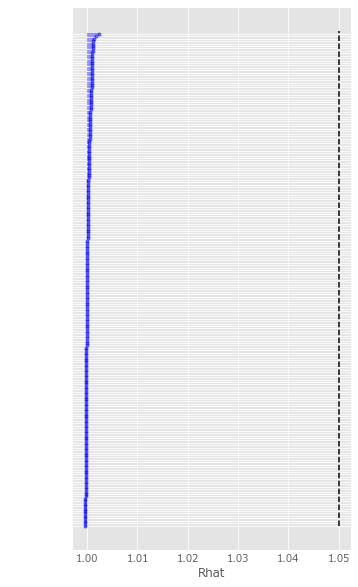

In [25]:
# 各推定結果のデータフレームを作成
summary_llpi = pd.DataFrame(
    local_level_prediction_interval.summary()['summary'],
    columns=local_level_prediction_interval.summary()['summary_colnames'],
    index=local_level_prediction_interval.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary_llpi)

## 参考：結果の表示

In [26]:
print(local_level_prediction_interval.stansummary(pars=["s_w", "s_v", "lp__"],
                                                  probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_d708c6aac7351d717bde7cc6d469ec51.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w    1.32    0.01    0.3   0.84   1.28   2.02    445    1.0
s_v    2.65  4.3e-3   0.29   2.13   2.64   3.25   4452    1.0
lp__ -181.0    0.95  18.79 -218.1 -180.9 -144.9    388    1.0

Samples were drawn using NUTS at Thu Sep 10 22:38:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 図示

### 生成された乱数を格納

In [27]:
mcmc_sample_prediction_interval = local_level_prediction_interval.extract()

### 図示

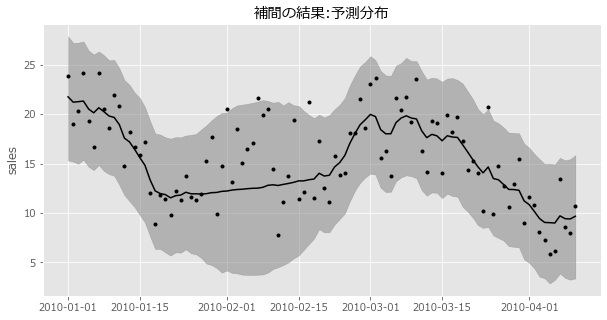

In [28]:
# グラフ描画領域の作成
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)

# plotSSM関数によるグラフ作成
plotSSM(mcmc_sample_prediction_interval,
        time_vec=sales_df_all['date'],
        obs_vec=sales_df_all['sales'],
        state_name='y_pred',
        graph_title='補間の結果:予測分布',
        y_label='sales',
        axes=ax)

# グラフの描画
plt.show()